# Reward curve figures for AmpC dataset

**NOTE:** This notebook assumes you have your directories organized like so
```
ROOT_DIRECTORY
├── full
│   ├── 0.001
│   │   ├── rep-0 <-- output directory of a MolPAL run
│   │  ...
│   │   └── rep-N
│   ├── 0.002
│   └── 0.004
└── prune
    ├── 0.001
    ├── 0.002
    └── 0.004
```

### Step 1: run the cells below to define the functions

In [2]:
from pathlib import Path
import sys
from typing import Iterable, List, Tuple

from matplotlib import pyplot as plt, patheffects as pe, ticker
import numpy as np
import scipy.interpolate
import seaborn as sns
from tqdm.notebook import tqdm

sys.path.append("../")
sys.path.append("../scripts/")
from scripts.experiment import Experiment
from scripts.utils import build_true_dict

sns.set_theme("talk", "white")

ROOT_DIR = Path.home() / "active-projects/molpal-pruning/runs/ampc"
SIZE = 98.2e6
k = 10000

def abbreviate_k_or_M(x: float, pos) -> str:
    if x >= 1e6:
        return f"{x*1e-6:0.1f}M"
    if x >= 1e3:
        return f"{x*1e-3:0.0f}k"

    return f"{x:0.0f}"

def pad_xss(xss: Iterable[Iterable]) -> np.ndarray:
    n = max(len(xs) for xs in xss)
    xss = [np.pad(xs, (0, n - len(xs)), constant_values=np.nan) for xs in xss]

    return np.array(xss, float)

def stack_curves(expts_dir: Path, top_k) -> np.ndarray:
    ys = []
    for p_exp in expts_dir.iterdir():
        e = Experiment(p_exp)
        ys.append(e.curve(top_k, "scores"))
    
    return pad_xss(ys)

def calc_reward(split, top_k: List[Tuple], reward: str = "scores"):
    Ys_full = []
    for p in tqdm((ROOT_DIR / "full" / split).iterdir(), desc="no pruning", leave=False):
        e = Experiment(p)
        Ys_full.append(e.curve(top_k, reward))
    Y_f = np.array(Ys_full)

    Ys_prune = []
    for p in tqdm((ROOT_DIR / "prune" / split).iterdir(), desc="pruning", leave=False):
        e = Experiment(p)
        Ys_prune.append(e.curve(top_k, reward))

    N = max(len(Y) for Y in Ys_prune)
    x_min = N
    for i in range(len(Ys_prune)):
        x_min = min(len(Ys_prune[i]), x_min)
        Ys_prune[i] = np.pad(Ys_prune[i], [(0, N - len(Ys_prune[i]))], "edge")
    Y_p = np.array(Ys_prune)

    return Y_f, Y_p, x_min

In [3]:
def plot_random_curve(ax, N):
    p = k / SIZE

    x = np.arange(N) + 1
    Y = np.cumsum(np.where(np.random.uniform(size=(10, N)) < p, 1, 0), 1) / k
    y_mean = np.nanmean(Y, 0)
    y_sd = np.nanstd(Y, 0)

    ax.plot(
        x, y_mean, color="grey", lw=2,
        path_effects=[pe.Stroke(linewidth=3, foreground="k"), pe.Normal()],
        label="random"
    )
    ax.fill_between(
        x, y_mean - y_sd, y_mean + y_sd, color="grey", dashes=":", lw=1., ec="black", alpha=0.3
    )

    return ax

def plot_reward(ax, Y_f, Y_p, x_min):
    sns.set_palette("dark")

    x = np.arange(Y_p.shape[1]) + 1

    Y_f = Y_f[:, :len(x)]
    y_f_mean = np.nanmean(Y_f, 0)
    y_f_sd = np.nanstd(Y_f, 0)

    ax.plot(
        x,
        y_f_mean,
        ls="solid",
        lw=2,
        path_effects=[pe.Stroke(linewidth=3, foreground="k"), pe.Normal()],
        label="no pruning"
    )
    ax.fill_between(
        x,
        y_f_mean - y_f_sd,
        y_f_mean + y_f_sd,
        dashes=":",
        lw=1.,
        ec="black",
        alpha=0.3
    )

    y_p_mean = np.nanmean(Y_p, 0)
    y_p_sd = np.nanstd(Y_p, 0)

    ax.plot(
        x,
        y_p_mean,
        ls="dashed",
        lw=2,
        path_effects=[pe.Stroke(linewidth=3, foreground="k"), pe.Normal()],
        label="pruning"
    )
    ax.fill_between(
        x,
        y_p_mean - y_p_sd,
        y_p_mean + y_p_sd,
        dashes=":",
        lw=1.,
        ec="black",
        alpha=0.3
    )

    plot_random_curve(ax, Y_p.shape[1])

    x_max = Y_p.shape[1]
    if x_min < x_max:
            ax.axvspan(x_min, x_max, color="grey", alpha=0.2)
    
    ax.set_ylim(-0.05, 1.05)
    formatter = ticker.FuncFormatter(abbreviate_k_or_M)
    ax.xaxis.set_major_formatter(formatter)
    ax.tick_params(axis="x", which="major", bottom=True, rotation=20)

    ax.grid(True, ls="--")

    ax.set_xlabel("Molecules explored")
    ax.set_ylabel(f"Fraction of Top-10000 Scores Found")
    ax.legend()

    return ax

In [36]:
def retained_idxss(expt: Experiment) -> List[np.ndarray]:
    return [np.load(chkpt / "retained_idxs.npy") for chkpt in expt.chkpts[:-1]]

def gcp_dollars(cpus: float = 0., gpus: float = 0) -> float:
    return cpus * 0.0475/60**2 + gpus * 2.48/60**2
    
def cost_curve(expt: Experiment, prune: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    n_tr = np.array(expt.num_acquired)[:-1]
    c_tr = n_tr * 6.16 / 400e3

    if prune:
        s = [SIZE]
        for I in retained_idxss(expt)[:-1]:
            s.append(len(I))
        n_pred = np.array(s)
        c_pred = n_pred * 20.52 / 98.2e6
    else:
        c_pred = 20.52 * (np.ones(expt.num_iters - 1))

    return n_tr, np.cumsum(c_pred + c_tr)

def align_cost_curves(X: np.ndarray, C_prune):
    x_new = X.max(0)
    C_prune_new = np.empty(C_prune.shape)

    for i, (x, c) in enumerate(zip(X, C_prune)):
        f = scipy.interpolate.interp1d(
            x, c, "previous", bounds_error=False, fill_value="extrapolate"
        )
        C_prune_new[i] = f(x_new)
        
    return C_prune_new

def gen_cost_curves(split: str):
    p = ROOT_DIR / "full" / split / "rep-0"
    x_f, c_f = cost_curve(Experiment(p), False)

    d_ampc_prune = ROOT_DIR / "prune"

    x_min, x_max = np.inf, -np.inf
    prune_curves = []
    for p_exp in (d_ampc_prune / split).iterdir():
        e = Experiment(p_exp)
        prune_curves.append(cost_curve(e, True))

        N_a_max = max(e.num_acquired)
        x_min = min(x_min, N_a_max)
        x_max = max(x_max, N_a_max)
        
    xs, prune_costs = zip(*prune_curves)
    X = np.array(xs)
    C_prune_new = align_cost_curves(X, np.array(prune_costs))

    mask = x_f < x_max
    x_f = x_f[mask]
    c_f = c_f[mask]

    return (x_f, c_f), (X.min(0), C_prune_new), (x_min, x_max)

In [30]:
def plot_cost(ax, x_f, c_f, x_p, C_p, x_min, x_max):
    sns.set_palette("dark")

    # (x_f, c_f), (x, x_max, C_p) = gen_cost_curves(split)
    # p = ROOT_DIR / "full" / split / "rep-0"
    # x_full, c_full = cost_curve(Experiment(p), False)

    # d_ampc_prune = ROOT_DIR / "prune"

    # x_min, x_max = np.inf, -np.inf
    # prune_curves = []
    # for p_exp in (d_ampc_prune / split).iterdir():
    #     e = Experiment(p_exp)
    #     prune_curves.append(cost_curve(e, True))

    #     N_a_max = max(e.num_acquired)
    #     x_min = min(x_min, N_a_max)
    #     x_max = max(x_max, N_a_max)
        
    # xs, prune_costs = zip(*prune_curves)
    # X = np.array(xs)
    # C_prune_new = align_cost_curves(X, np.array(prune_costs))

    # mask = x_full < x_max
    # x_full = x_full[mask]
    # c_full = c_full[mask]

    lines = ax.plot(
        x_f, c_f, 'o',
        mec='k', mew=2, label="no pruning"
    )
    ax.step(
        [0, *x_f, x_max], [0, *c_f, c_f[-1]], '-', where="post",
        color=lines[0].get_color()
    )

    # x = X.min(0)
    ebars = ax.errorbar(
        x_p, C_p.mean(0), yerr=C_p.std(0), fmt='o',
        mec='k', mew=2, capsize=5, label="pruning"
    )
    ax.step(
        [0, *x_p, x_max], [0, *C_p.mean(0), C_p.mean(0)[-1]], '--', 
        where="post", color=ebars.lines[0].get_color()
    )

    ax.axvspan(x_min, x_max, color="grey", alpha=0.2)
    
    ax.set_xlabel("Molecules Explored")
    ax.set_ylabel("Overhead Cost / $")
    ax.grid(True, ls="--")

    formatter = ticker.FuncFormatter(abbreviate_k_or_M)
    ax.xaxis.set_major_formatter(formatter)
    ax.tick_params(axis="x", rotation=20)
    
    return ax

### Step 2: get the top-$k$ points for the datasets

In [6]:
ampc_scores = build_true_dict(Path.home() / "molpal/data/AmpC_glide_scores_top200k.csv")
ampc_top_k = sorted(ampc_scores.items(), key=lambda kv: kv[1], reverse=True)[:k]

### Step 3: run the cells below with your desired split size

**Note**: The value of `split` should be the name of the folder containing the results on your file system (see the top of this notebook for details)

In [39]:
split = "0.001"
Y_f, Y_p, x_min = calc_reward(split, ampc_top_k)
(x_f, c_f), (x_p, C_p), (x_min, x_max) = gen_cost_curves(split)

no pruning: 0it [00:00, ?it/s]

pruning: 0it [00:00, ?it/s]

In [40]:
x_f, x_p, x_min, x_max

(array([ 98227, 196454, 294681, 392908, 491135]),
 array([ 98227, 196454, 294681, 392908, 473661]),
 473661,
 507475)

Text(0.0, 1.0, 'B')

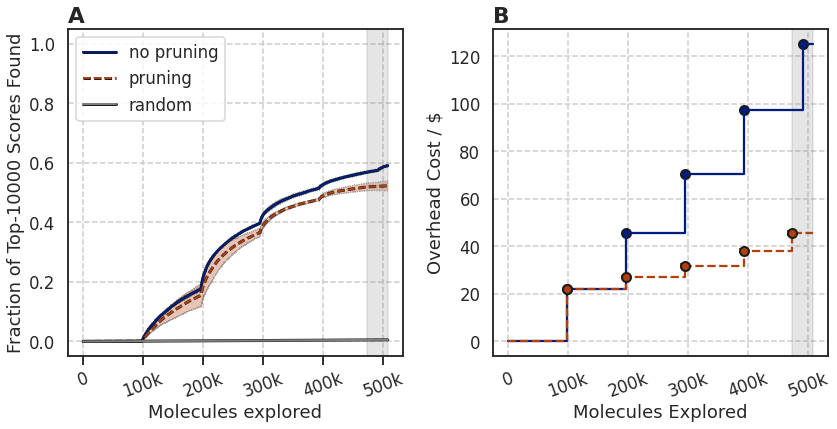

In [41]:
sns.set_palette("dark")
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

plot_reward(axs[0], Y_f, Y_p, x_min)
plot_cost(axs[1], x_f, c_f, x_p, C_p, x_min, x_max)

fig.tight_layout()

axs[0].set_title("A", weight="bold", loc="left", fontsize="large")
axs[1].set_title("B", weight="bold", loc="left", fontsize="large")

In [8]:
fig.savefig(f"../figures/ampc-{split[2:]}-curves+cost-10k.png", dpi=400)

NameError: name 'fig' is not defined